# Time Series Modeling of Order Volume Data

## Research Question

My research question for this project is: **​To what extent can daily order volume be predicted?** This is questioned in the context of an e-commerce store that sees a significant lift in sales during the holiday season. At that time and less so at every time throughout the year, it is very necessary to have an accurate estimate of the anticipated number of orders the store will be receiving. This is in order to properly stock inventory and effectively staff warehouses, making this question an essential one to answer. I would predict that the answer to my question is that a highly accurate prediction can be made, even over 90%.

## Data Collection

In order to predict future order volume, I depend on historical order volume. So that is what I collected. Historical order volume of a single online e-commerce store. It is one single simple time series, a column for the date and a column for the count of orders on that day. It was extracted using a SQL query from the analytical database, where it was copied from a transactional database, which transactional database was fed by an API.

This is one disadvantage of the method by which I extracted this data. It has passed through many different hands and is now 2 times removed from the source of truth (the API). This makes it potentially inaccurate because many touch points often mean many places for things to break, and code out of the analyst's control can make it not always feasible to confirm the accuracy of those replications.

An advantage of pulling it from the OLAP Database rather than directly from the API is that it will always give a consistent answer. APIs should be trusted for accuracy (depending on their SLA), but they are not always consistent. Sometimes, when you request one thing, it will give a response, and then when you request the same thing again, it will give a different response. However, you will always get the same result with the database query. And in training for machine learning, consistency is incredibly important. So, this is a major advantage of the database query over a direct pull from the API.

I did not encounter any issues while collecting this data using this method.

The query I used to collect the data is below:

In [ ]:
select
    shopifycreatedat::date as date,
    count(distinct shopify_id) as count
from 
    staging.mongodb.stg_orders
where 
    shopifycreatedat::date >= '2015-01-20' -- first sale
    and shopifycreatedat::date <= '2024-12-31' -- end of most recent calendar year
group by all
order by date
;

## Data Extraction and Preparation

The Data extraction and preparation process happened in the following sequence of steps (with their associated code blocks)

#### Step 1
The relevant libraries and packages are imported into the notebook for use. Most notably, here is the Pandas library, which will be the backbone of the entire analysis. The major advantage of the Pandas library is its widespread adoption and support. There are countless articles and forums online that help answer questions about it, which makes it very easy to use. The one disadvantage is that it is relatively old and so now significantly slower than other options on the market, particularly when working with very large datasets. 

In our case, we will be loading the data from the SQL query into a pandas data frame. We will then convert the DATE column from the query response into the index of that data frame and mark it as being at the interval of days. Lastly, we will convert the index and the variable into their anticipated data types. Pandas library already has built-in functions for all this, so it is as simple as calling those functions. As seen below:

In [25]:
## LIBRARIES / PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal, stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [26]:
## LOAD DATA
ts_df = pd.read_csv('store_orders.csv')
ts_df.set_index('DATE', inplace=True)
ts_df.index = pd.DatetimeIndex(ts_df.index).to_period('D')
ts_df.index = ts_df.index.to_timestamp()
ts_df['COUNT'] = ts_df['COUNT'].astype(int)

#### Step 2
The next step in our data preparation process is to confirm the datatypes of our index and variable and also to assess common statistical measures of a time series (min, mean, max, etc). This assessment aids in planning the next steps of the data preparation process.

In [27]:
## CONFIRM DATATYPES, RANGE, AND UNIQUENESS
print(ts_df.describe())
print("Data type of the time column of the Realization: ", ts_df.index.dtype) # All only timestamps
print("Data type of the time column of the Realization: ", ts_df['COUNT'].dtype) # All only integers
print("Length of unique values in the Realization: ", len(ts_df.index.unique())) # all unique values

             COUNT
count  3631.000000
mean    139.740292
std     157.632884
min       1.000000
25%      71.000000
50%     109.000000
75%     155.000000
max    4458.000000
Data type of the time column of the Realization:  datetime64[ns]
Data type of the time column of the Realization:  int64
Length of unique values in the Realization:  3631


#### Step 3
Our assessment showed us only having 3631 total records in our data frame. However, between January 20, 2014, and December 31, 2024 (our date range), there are 3634 days. Meaning we have a few missing days from our dataset. Because of the way the data was collected, we know that if a date is missing, there were no sales on that date. So, these missing days should be added in and backfilled with zero as the count. The Pandas library also has a function that can do this for us.

In [28]:
## FILL IN MISSING DATES WITH 0 (NO ORDERS PLACED)
ts_df = ts_df.resample('1D').mean().fillna(0)

#### Step 4
Furthermore, our assessment showed us that despite having a mean in the mid-100s, the max day was over 30 times as large. This is anomalous and likely represents either a fault in the data or an outside pressure/effect driving sales on that day that is not being accounted for in this analysis. As a reminder, we are trying to estimate orders on regular days and days affected by regularly recurring seasonality, not random spikes from sales that should be accounted for separately. So regardless of whatever is driving that max day and others like it, they need to be removed. In comes our next two tools:
- Scipy is a stats module with lots of built-in statistical functions. Here, we are using it for a z score across the counts column, which we can use as its standard deviation. A big advantage of Scipy is that it is a best-in-class stats module and is very frequently recommended. A disadvantage, though, is that it is not as all-encompassing and powerful as other libraries like it.  
- Numpy is a data array mathematical module that proves its worth simply by the number of other commonplace libraries that internally depend on it. It is prevalent everywhere, and beyond its limitations in the data types it can operate on, it has no apparent disadvantages. In our use case, we will simply be using it to apply an absolute value operation across the entirety of the z-score array at once.  

By comparing the absolute value of the z-score on each day, we can effectively remove any instances in our realization where that day's value exceeded a standard deviation of 3. And that is how we remove the outliers.

In [29]:
## REMOVE OUTLIERS
ts_df = ts_df[(np.abs(stats.zscore(ts_df['COUNT'])) < 3)]

#### Step 5
Lastly, to finish up our data preparation, we will visualize our data through both a sampling of the data frame and through a plot of the realization as it now stands. To do this, we will use MatPlotLib. A very well-supported and functional tool for visualizations, though often known for producing ugly graphs. We will also write out the prepared dataset in a new CSV file for saving.

,COUNT
DATE,
2015-01-20,1.0
2015-01-21,0.0
...,...
2024-12-30,134.0
2024-12-31,61.0


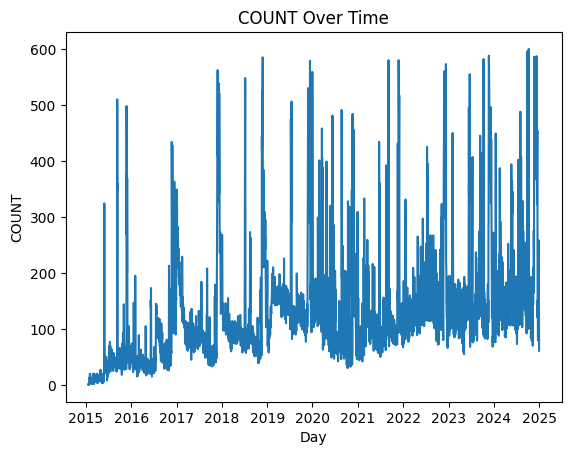

In [30]:
## DISPLAY DATA
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(ts_df)
    
plt.plot(ts_df)
plt.title('COUNT Over Time')
plt.xlabel('Day')
plt.ylabel('COUNT')
plt.show()

ts_df.to_csv('prepared_store_orders.csv')

## Analysis

I will be using various tools, techniques, and calculations in preparation for and as part of this analysis. I will break down my usage of each tool in each step throughout the analysis.

#### AD Fuller Test for Stationarity

The analysis begins with a sanity check across the realization/dataset to confirm statistically that the dataset is ready for an ARIMA test. This qualification it must meet is the standard of Stationarity, and it can be determined by a statistical test called the AD Fuller test. Below, I will run the AD Fuller test and output its results. The different critical values listed there mark the result value at which we would have the associated P values. It shows that anything less than a -3 result would have given us sufficient statistical significance to declare the data was stationary. Our value of -7 was well beyond that. 

In [31]:
result = adfuller(ts_df.COUNT)
print('Result: ', result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t', key, '%: ', value)

Result:  -7.73826494996784
p-value:  1.0790129097927253e-11
Critical Values:
	 1% %:  -3.4321902774899167
	 5% %:  -2.8623531309983417
	 10% %:  -2.5672028430631353


#### (Partial) AutoCorrelation Functions

The next test I did as a part of the analysis was an Autocorrelation / Partial Autocorrelation Function. These two plots go hand in hand as they both tell different parts of the correlation story of a time series. More importantly, they can be used to determine the proper input parameters for the ARIMA model, which is what I will be using them for here.

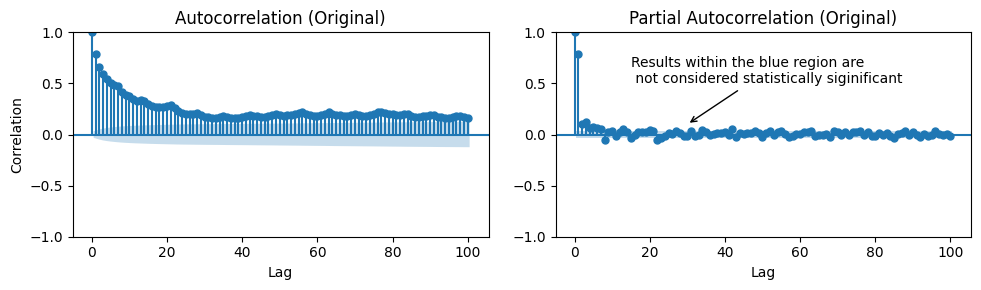

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot ACF
plot_acf(ts_df['COUNT'], lags=100, ax=axes[0], title='Autocorrelation (Original)')
axes[0].set(xlabel='Lag')
axes[0].set(ylabel='Correlation')

# Plot PACF
plot_pacf(ts_df['COUNT'], lags=100, ax=axes[1], title='Partial Autocorrelation (Original)')
axes[1].set(xlabel='Lag')
axes[1].annotate("Results within the blue region are\n not considered statistically significant", xy=(30, 0.1), xytext=(15, 0.5), arrowprops=dict(arrowstyle="->"))

fig.tight_layout()

#### Decomposition

Another test in preparation for the ARIMA model is a decomposition visual. This is primarily to tell me what kind of model needs to be used. The trend graph and its gradual slope upwards tell me softly that I need a differencing layer, and the extreme waves in the seasonality graph tell me I need to handle that seasonality in the model type. Of course, this seasonality was already known due to our original research question and associated hypothesis. However, it is always good to confirm those assumptions from the exploration phase while using the actual training data.

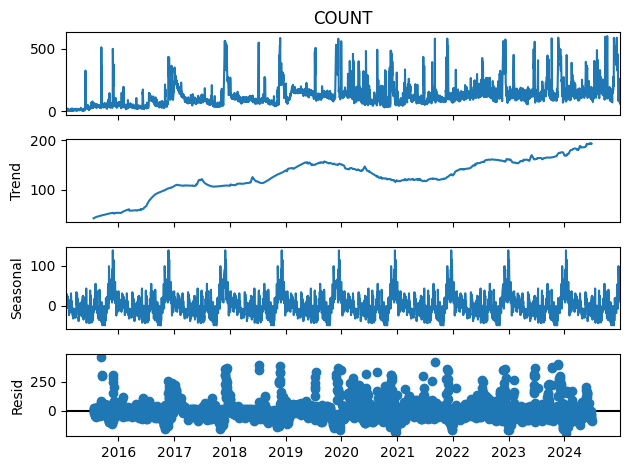

In [ ]:
# Decomposition of Original Set
decomp = sm.tsa.seasonal_decompose(ts_df['COUNT'], period=365)
decomp.plot(observed=True, trend=True, seasonal=True, resid=True);

#### Model Training

Now, to the actual model training. For my analysis of the data, I will be performing a time series analysis using the ARIMA technique. ARIMA stands for AutoRegressive Integral Moving Average, which are two different techniques that are joined together at the hip. The autoregressive approach to time series brings with it some major advantages, like its pattern replication ability and its lightweight calculations. The moving average approach has advantages that it brings as well, primarily in its ability to not overfit and try to match future projections to every little movement that has happened in the past. It does this by using a moving window average rather than a single-point projection. Combined with the integration aspect, which is just the differencing of the data, both advantages can be enjoyed with an ARIMA model. The ARIMA model does have some downsides as well, in particular, its inability to capture complex or dynamic fluctuations into its predictions. However, for simple linear growths and seasonal shifts, ARIMA is an industry standard that has been hallmarked for its prowess. This and the advantages mentioned here are why I selected ARIMA for this analysis.

The version of ARIMA I selected was the SARIMAX model by the statsmodels library. This model allows for the inputs of a seasonal factor that helps to align the patterns seen seasonally into its future predictions. I am also, at this point, splitting the dataset into a testing and a training set so that I can get a comparison of the results the model produces and the real-life values. Using this comparison, I can compute an error result and an accuracy marker.

In [115]:
p = 2
d = 1
q = 1
s = 52
train_size = int(len(ts_df) * 0.8)


# Train Model
train, test = ts_df[:train_size], ts_df[train_size:]
model = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, s))
model_fit = model.fit()

/Users/landenbailey/.pyenv/versions/3.12.0/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/landenbailey/.pyenv/versions/3.12.0/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46029D+00    |proj g|=  4.33390D-02


 This problem is unconstrained.



At iterate    5    f=  5.41416D+00    |proj g|=  1.16442D-02

At iterate   10    f=  5.40285D+00    |proj g|=  1.00612D-02

At iterate   15    f=  5.35645D+00    |proj g|=  2.74766D-02

At iterate   20    f=  5.33531D+00    |proj g|=  1.44339D-01

At iterate   25    f=  5.31753D+00    |proj g|=  4.34918D-04

At iterate   30    f=  5.31753D+00    |proj g|=  1.52175D-03

At iterate   35    f=  5.31686D+00    |proj g|=  4.57262D-02

At iterate   40    f=  5.31429D+00    |proj g|=  6.12450D-03

At iterate   45    f=  5.31417D+00    |proj g|=  3.20063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     67   

#### Forecasting

Now that the model has been trained, we are going to forecast the next steps of the same length as the test sequence. Then, compare visually first and mathematically second. The visual comparison we are doing here just involves using matplotlib to plot the predicted values with actual values over top of each other on the same graph. I will also be including the confidence intervals. We will do a full summary of this result later on, but the initial look is disappointing. The forecast appears to have correctly identified the trend of the realization, but it seems to have failed to identify a proper pattern in the seasonality and made no aggressive predictions. As such, the forecast graph is significantly calmer here than the actual results.

/Users/landenbailey/.pyenv/versions/3.12.0/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/landenbailey/.pyenv/versions/3.12.0/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


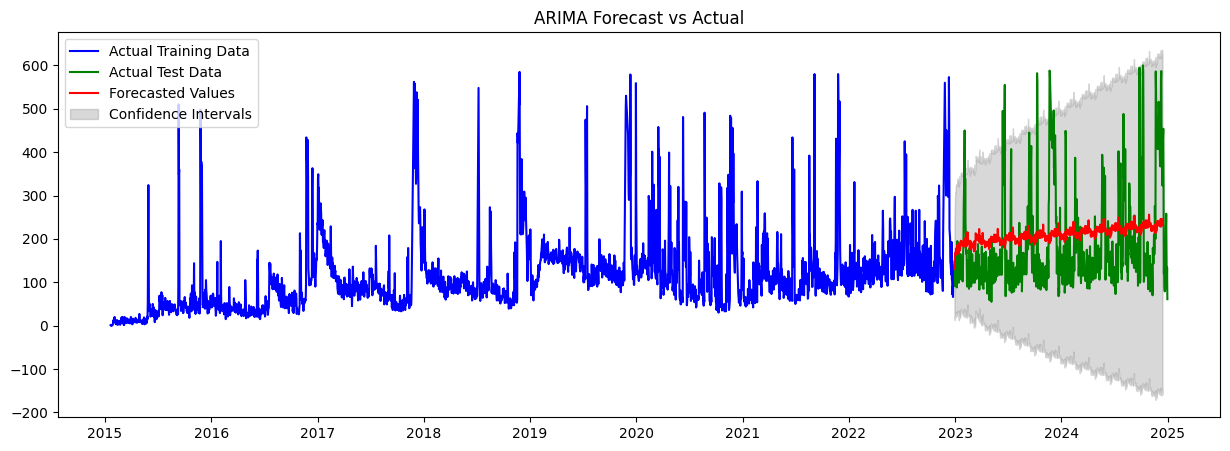

RMSE: 107.99230373682316


In [121]:
forecast = model_fit.get_forecast(steps=len(test))
mean_forecast = forecast.predicted_mean
conf_inter = forecast.conf_int()
mean_forecast.index = pd.date_range(start=test.iloc[0].name, periods=len(mean_forecast), freq='D')
conf_inter.index = pd.date_range(start=test.iloc[0].name, periods=len(mean_forecast), freq='D')
lower_conf = conf_inter.iloc[:, 0]
upper_conf = conf_inter.iloc[:, 1]

plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='Actual Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(mean_forecast.index, mean_forecast, label='Forecasted Values', color='red')
plt.fill_between(lower_conf.index, lower_conf, upper_conf, label='Confidence Intervals', color='gray', alpha=0.3)
plt.legend(loc='upper left')
plt.title('ARIMA Forecast vs Actual')
plt.show()

#### Error Checks and Accuracy

Lastly, the mathematical checks of the error rate and the accuracy of our solution are also included. I am using the Root Mean Squared error test to compare the forecasted results with the actual values set aside for the testing. The root mean square error is very popular and is regularly used for statistical error testing. Its parent test (MSE) is considered one of the best ways to measure error between two datasets. Adding the Root part to the test converts the units of the error result back into the same units as the original datasets, which makes it all the better to work with. The one big disadvantage of MSE and RMSE is their sensitivity to outliers. Since the test depends on a square, if there is an extreme error, its effect will be exponentiated in the error check. But considering our removal of the outliers at the beginning of all this, we will avoid that disadvantage largely.

So, after running the tests, we got an RMSE value of just about 108. It's in the same units as before, so this means that, on average, our predictions were off from the actual answer by 108 units ordered on that day. That is not good. To calculate an accuracy percentage, we need to know how big of a percentage 108 is of the average number of orders done that day. Then, we'll divide them and subtract the result from one. That gives us an accuracy calculation of just under 40%. In other words, The model accurately predicted 40% of the orders on any given day. And it just missed completely on the other 60%.

In [123]:
# Evaluate model performance on the test set
rmse = np.sqrt(mean_squared_error(test["COUNT"], forecast.predicted_mean))
print(f"RMSE: {rmse}")

print(f"Accuracy: {1 - rmse / test["COUNT"].mean()}")

RMSE: 107.99230373682316
Accuracy: 0.3957386608870963


## Data Summary and Implications

Coming into this analysis, the question we aimed to answer was "To what degree can Daily Order Volume be Predicted?" given the results of our forecast, we can now answer: "Using the ARIMA model for the forecast, Daily Order Volume can be predicted to within an average error discrepancy of 108 units per day." In other terminologies, orders can only be predicted with ~40% accuracy. This means that for this analysis, we fail to reject the null hypothesis as there is no statistical support for the accuracy of our model predictions.

The model we built had many limitations to it. It likely could have been parameter-tuned more effectively, and we could have sampled different testing ranges to get slightly better results. But I don't believe they would have been significantly better than what we were able to achieve as is because the largest limitation of the model was the technique itself. I mentioned when reviewing the disadvantages of the ARIMA model that while it is very good at picking up on trends and simple patterns, it falls dramatically short when trying to interpret and forecast complex dynamic patterns. It also can't handle nonstationary data at all, and it crumples under the presence of outliers. Our dataset had all 3 of those in bounty.

Even though we removed all of the statistical outliers across the entire dataset, because of the moving window average that arima performs, the outliers that are throwing it off will be outliers within its little moving window, dramatic jumps day over day, which were all over the place in the dataset. Our differenceing of the dataset removed any trending from it, but the failure to converge in the autocorrelation function plot was an indication that autocorrelation still existed amongst the elements in the set, meaning that the data was still not stationary, which caused problems as well. Lastly and most significantly, the extreme and dynamic pattern that existed in our data was just too wild and unpredictable for a model as lightweight as ARIMA to get a hold of. With dramatic ups and downs in orders day over day and week over week, ARIMA could have trained for a year but still never found the pattern (assuming there is even one to be found). It just was not the right tool to use for this specific dataset.

Regardless of the failure of this analysis, the company still needs to have an accurate forecast of orders to optimize warehouse efforts. It is my belief, though, that the results of this analysis are poor enough that if they are used for planning purposes, they will do more harm than good. Whatever system of just guessing that is currently being done should stay in place until a better forecast is produced.

As for the next steps that I think should be taken to create a better model, I think there are two other approaches that could be used, and both should probably be trialed. 
1. Continue working with an ARIMA-based model but on a dataset that is a lot more pre-massaged. Run a difference function on the dataset by days of the week first, then do it by the day of the year. Find days that were having large sales and remove them. Do any iteration of data massaging before the model sees the data to help reduce all of the limitations that ARIMA had with it the first round through. These changes will likely improve the error rate.
2. Use a completely different technique, in particular, an RNN. Deep learning is a very powerful tool that, if used correctly, can recognize patterns that no human could ever find. A Recurrent Neural Network, in particular, is designed for a series of data that flows sequentially. I think without excessive manipulation of the data at all, a well-trained RNN could easily predict a forecast for daily order volume with very low rates of error.

## Works Cited

- AnonRocketman, & Stephan Kolassa. (1966, December 1). What are the downsides of Arima models?. Cross Validated. https://stats.stackexchange.com/questions/558252/what-are-the-downsides-of-arima-models 
- Data, T. in. (2024, March 23). Seasonal time series forecasting: Key techniques. Train in Data's Blog. https://www.blog.trainindata.com/seasonal-time-series-forecasting/ 
- Root mean square error (RMSE) in AI: What you need to know. Arize AI. (2024, April 8). https://arize.com/blog-course/root-mean-square-error-rmse-what-you-need-to-know/ 